In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
from Libro_Vision_Artificial import funciones_umbrales as fun
import math
from skimage import exposure

In [14]:
path = 'Fotos_Nuevas/transformadas/'
name = '3_new_'
img = cv2.imread(path+name+'recortada.jpg') #BGR

In [3]:
def show_img(img, title='img'):
    cv2.imshow(title, img)
    cv2.waitKey()
    cv2.destroyAllWindows()

## Fase 0. Visualizar histogramas

In [4]:
def calcHistogram(img, canal=0):
    height = 0
    width = 0
    gray = False
    try:
        height, width, channels = img.shape
    except ValueError:
        height, width = img.shape
        gray = True
    histArray =  []
    for x in range(255):
        histArray.append(0)
    for i in range(height):
        for j in range(width):
            if gray:
                histArray[int(img.item(i,j))] += 1
            else:
                histArray[int(img.item(i,j,canal))] += 1
    return histArray

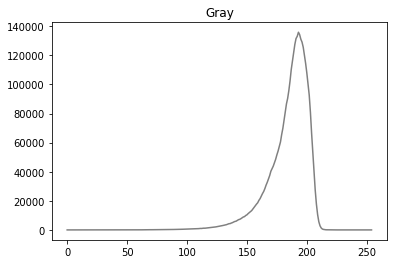

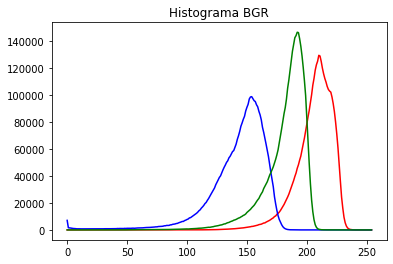

In [5]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
histGray = calcHistogram(gray,0)
plt.title('Gray')
plt.plot(histGray, color='gray')
plt.savefig(path+name+'histograma_gray.jpg')
plt.show()
histRed = calcHistogram(img, 2)
plt.plot(histRed, color='red')
histBlue = calcHistogram(img, 0)
plt.plot(histBlue, color='blue')
histGreen = calcHistogram(img, 1)
plt.plot(histGreen, color='green')
plt.title("Histograma BGR")
plt.savefig(path+name+'histograma_bgr.jpg')
plt.show()

## Fase 1: Procesamiento de la imagen

### 1.1 Extraer canal rojo 

In [15]:
img = cv2.imread(path+name+'recortada.jpg') #BGR
b = img[:,:,0]
g = img[:,:,1]
r = img[:,:,2]
red = img.copy()
red[:,:,0] = 0
red[:,:,1] = 0

In [16]:
show_img(red)
cv2.imwrite(path+name+'red.jpg', red)

True

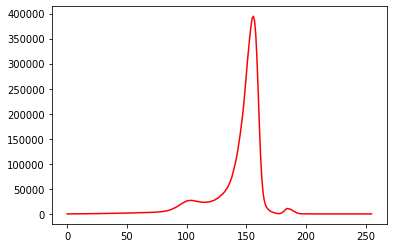

In [17]:
opencvHistRed = cv2.calcHist([img],[2], None, [256],[0,256])
plt.plot(opencvHistRed, color='red')
plt.savefig(path+name+'histograma_red.jpg')
plt.show()

In [9]:
print("Nivel con mayor concentración de pixeles: "+str(np.where(opencvHistRed == np.amax(opencvHistRed))))

Nivel con mayor concentración de pixeles: (array([210], dtype=int64), array([0], dtype=int64))


### 1.2 Binarizar

#### Opcion 1: Directamente

In [10]:
gray = cv2.cvtColor(red, cv2.COLOR_BGR2GRAY)
out = np.empty_like(gray)
fun.kittler(gray, out)
show_img(out)

In [11]:
cv2.imwrite(path+name+'kittler_red.jpg', out)

True

#### Opcion 2: Erosionar y dilatar

In [18]:
kernel = np.ones((5,5), np.uint8) 
dilation = cv2.dilate(red, kernel, iterations=1)
erosion = cv2.erode(dilation, kernel, iterations=1)
#dilation = cv2.dilate(erosion, kernel, iterations=3)

In [20]:
gray = cv2.cvtColor(erosion, cv2.COLOR_BGR2GRAY)
out = np.empty_like(gray)
fun.kittler(gray, out)
show_img(out)

In [21]:
cv2.imwrite(path+name+'red_erodil_kittler.jpg', out)

True

### 1.3 Extraer contornos y Dibujarlos 

In [15]:
(cont, jer) = cv2.findContours(out, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
print(len(cont))

1598


In [16]:
contsArray = cv2.drawContours(img, cont, -1, (0, 0, 255), 2, cv2.LINE_AA) #roja

In [17]:
show_img(img)

In [18]:
cv2.imwrite(path+name+'kittler_red_erodil_contours.jpg', img)

True


## Fase 2. Extracción de características

### 2.1 Momentos centrales

In [19]:
import json
img = cv2.imread(path+name+'recortada.JPG') #BGR
font = cv2.FONT_HERSHEY_SIMPLEX
contador = 0
antC = 0
arrayGrafR = []
arrayGrafG = []
arrayGrafB = []
arrayGrafVmR = []
arrayGrafBmR = []
arrayGrafVarroaR = []
arrayGrafVarroaG = []
arrayGrafVarroaB = []
arrayGrafVmRVarroa = []
arrayGrafBmRVarroa = []
selectedCont = []

for c in cont:
    #Calcular el centro a partir de los momentos
    area = cv2.contourArea(c)
    ispoint = False
    if area > 0:
        momentos = cv2.moments(c)
        cx = int(momentos['m10']/momentos['m00'])
        cy = int(momentos['m01']/momentos['m00'])
        if cx > 810 and cx < 840 and cy > 710 and cy < 750:
            print("Punto con centro en: ({},{})".format(cx,cy))
            print("Momento central (2,0) horizontal: {}".format(momentos['mu20']))
            print("Momento central (0,2) vertical: {}".format(momentos['mu02']))
            print("Area: {}".format(area))
            ellipse = cv2.fitEllipse(c)
            print("Ellipse: {}".format(ellipse))
            cv2.drawContours(img, [c], 0, (255, 0, 0), 2, cv2.LINE_AA) #azul
            ispoint = True


        if momentos['m02'] > momentos['m20']:
            ex = math.sqrt((momentos['m02']*momentos['m02']) - (momentos['m20']*momentos['m20']))/momentos['m02']
        else:
            ex = math.sqrt((momentos['m20']*momentos['m20']) - (momentos['m02']*momentos['m02']))/momentos['m20']

        area = cv2.contourArea(c)
        #print("Excentricidad: {}".format(ex))
        #print("Area: {}".format(area))

        pi_4 = np.pi*4

        #cv2.drawContours(img, [c], 0, (0, 0, 255), 2, cv2.LINE_AA) #rojo
        #cv2.putText(img,"(l: "+str(len(c))+")",(cx+10,cy+10), font, 0.5,(255,255,255),1)

        #epsilon = 0.01*cv2.arcLength(c,True)
        #c = cv2.approxPolyDP(c, epsilon, True)
        
        if len(c) > 5:
            arclen = cv2.arcLength(c, True)
            circularity = (pi_4 * area) / (arclen*arclen)
                  
            ellipse = cv2.fitEllipse(c) #((centroX, centroY), (semiejeMenor, simiejeMayor), anguloRotacion)
            poly = cv2.ellipse2Poly((int(ellipse[0][0]), int(ellipse[0][1])), (int(ellipse[1][0] / 2), int(ellipse[1][1] / 2)), int(ellipse[2]), 0, 360, 5)

            exEl = math.sqrt((ellipse[1][1]*ellipse[1][1])-(ellipse[1][0]*ellipse[1][0]))/ellipse[1][1]

            grain = np.int0(cv2.boxPoints(cv2.minAreaRect(c)))
            centroid =(grain[2][1]-(grain[2][1]-grain[0][1])//2, grain[2][0]-(grain[2][0]-grain[0][0])//2)
            color = img[centroid]
            if ispoint: 
                print("Color(B,G,R): {}".format(color))
                x = str(cx)+','+str(cy)+','+str(momentos['mu20'])+','+str(momentos['mu02'])+','+str(area)+','+str(ellipse[0][0])+','+str(ellipse[0][1])+','+str(ellipse[1][0])+','+str(ellipse[1][1])+','+str(color[0])+','+str(color[1])+','+str(color[2])
                
                print(x)
            arrayGrafB.append((color[0], exEl))
            arrayGrafG.append((color[1], exEl))
            arrayGrafR.append((color[2], exEl))
            arrayGrafVmR.append((color[2]-color[1],exEl))
            arrayGrafBmR.append((color[2]-color[0],exEl))
            
            #cv2.drawContours(img, [c], 0, (0, 0, 255), 2, cv2.LINE_AA) #rojo
            #cv2.putText(img,"(e: "+str(color[0])+")",(cx+10,cy+10), font, 0.5,(255,255,255),1)

            if True:#color[2] > 75 and color[2] < 120 and color[0] < 20 and color[1] > 10 and color[1] < 60:
                if area > 30 and area < 90:    
                    if ellipse[1][0] > 7 and ellipse[1][0] < 10 and ellipse[1][1] > 7 and ellipse[1][1] < 13 :
                        #cv2.drawContours(img, [c], 0, (255, 0, 0), 2, cv2.LINE_AA) #azul
                        contador+=1
                        #cv2.putText(img,"(r: "+str(color[2])+")",(cx+10,cy+10), font, 0.5,(255,255,255),1)
                        arrayGrafVarroaR.append((color[2], exEl))
                        arrayGrafVarroaG.append((color[1], exEl))
                        arrayGrafVarroaB.append((color[0], exEl))
                        arrayGrafVmRVarroa.append((color[2]-color[1],exEl))
                        arrayGrafBmRVarroa.append((color[2]-color[0],exEl))

                        selectedCont.append(c)
                        
                    """
                    print("Circularidad: {}".format(circularity))
                    if circularity > 0.6:
                        cv2.drawContours(img, [c], 0, (255, 0, 0), 2, cv2.LINE_AA) #azul
                        contador+=1
                        antC = c

                    cv2.putText(img,"(a: "+str(area)+")",(cx+10,cy+10), font, 0.5,(255,255,255),1)

                    similarity = cv2.matchShapes(poly.reshape((poly.shape[0], 1, poly.shape[1])), c, cv2.CONTOURS_MATCH_I2, 0)
                    print("Similaridad: {}".format(similarity))
                    if similarity <= 0.2:
                        #cv2.drawContours(img, [c], 0, (0, 255, 0), 2, cv2.LINE_AA) #verde
                        #cv2.polylines(img, [poly], True, (0,255,0)) #verde
                        #cv2.ellipse(img, ellipse, (0,255,0))
                        if c.all()!=antC.all():
                            contador+=1 """
                    #print("Elipse: ",exEl)
        #print("--------------------------------------------")
print("Hay {} varroas".format(contador))

Punto con centro en: (491,732)
Momento central (2,0) horizontal: 914.2023809477687
Momento central (0,2) vertical: 530.5723443105817
Area: 91.0
Ellipse: ((491.8311767578125, 732.4989013671875), (9.283452987670898, 13.863940238952637), 119.1246566772461)
Color(B,G,R): [16 32 85]
491,732,914.2023809477687,530.5723443105817,91.0,491.8311767578125,732.4989013671875,9.283452987670898,13.863940238952637,16,32,85
Hay 812 varroas


In [17]:
cv2.imwrite(path+name+'excentricidad_metricas_excel.jpg', img)

True

In [15]:
print("Hay {} varroas".format(contador))

Hay 67 varroas


### 2.2 Graficos

#### Gráficos según color

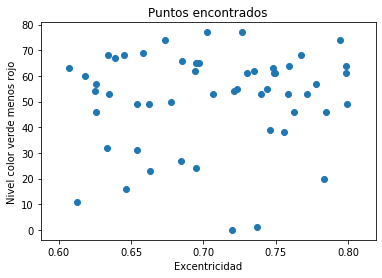

In [38]:
verderojo, ex = zip(*arrayGrafVmRVarroa)
plt.scatter(ex,verderojo)
plt.title('Puntos encontrados')
plt.xlabel("Excentricidad")
plt.ylabel("Nivel color rojo menos verde")
plt.savefig(path+name+'grafico_ex_red-verde.jpg')
plt.show()

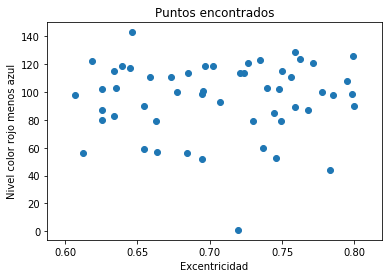

In [40]:
azulrojo, ex = zip(*arrayGrafBmRVarroa)
plt.scatter(ex,azulrojo)
plt.title('Puntos encontrados')
plt.xlabel("Excentricidad")
plt.ylabel("Nivel color rojo menos azul")
plt.savefig(path+name+'grafico_ex_red-blue.jpg')
plt.show()

In [22]:
rojo,excentricidad = zip(*arrayGrafR)
rojoVarroa, excentricidadVarroa = zip(*arrayGrafVarroaR)

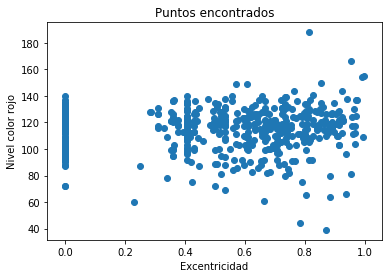

In [51]:
plt.scatter(excentricidad,rojo)
plt.title('Puntos encontrados')
plt.xlabel("Excentricidad")
plt.ylabel("Nivel color rojo")
plt.savefig(path+name+'grafico_ex_red.jpg')
plt.show()

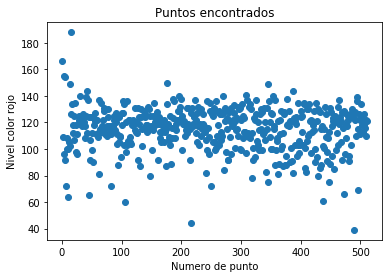

In [26]:
plt.scatter(range(1,len(rojo)+1),rojo)
plt.title('Puntos encontrados')
plt.xlabel("Numero de punto")
plt.ylabel("Nivel color rojo")
plt.show()

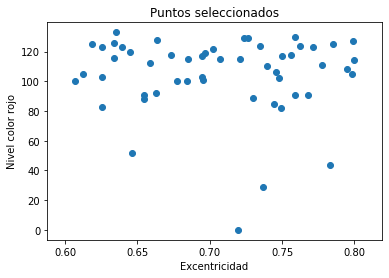

In [52]:
plt.scatter(excentricidadVarroa,rojoVarroa)
plt.title('Puntos seleccionados')
plt.xlabel("Excentricidad")
plt.ylabel("Nivel color rojo")
plt.savefig(path+name+'grafico_ex_red_selec.jpg')
plt.show()

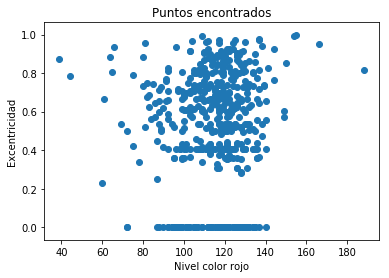

In [152]:
plt.scatter(rojo,excentricidad)
plt.title('Puntos encontrados')
plt.xlabel("Nivel color rojo")
plt.ylabel("Excentricidad")
plt.savefig(path+name+'grafico_red_ex.jpg')
plt.show()

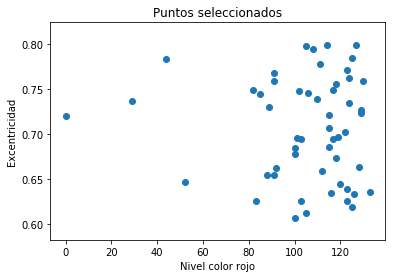

In [153]:
plt.scatter(rojoVarroa, excentricidadVarroa)
plt.title('Puntos seleccionados')
plt.xlabel("Nivel color rojo")
plt.ylabel("Excentricidad")
plt.savefig(path+name+'grafico_red_ex_selec.jpg')
plt.show()

In [28]:
azul,excentricidad = zip(*arrayGrafB)

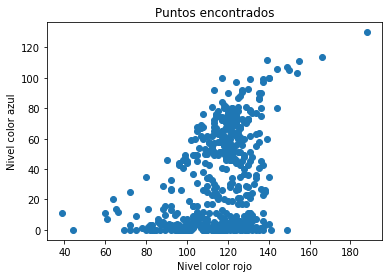

In [29]:
plt.scatter(rojo,azul)
plt.title('Puntos encontrados')
plt.xlabel("Nivel color rojo")
plt.ylabel("Nivel color azul")
plt.savefig(path+name+'grafico_red_blue.jpg')
plt.show()

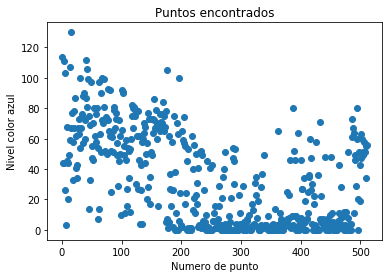

In [30]:
plt.scatter(range(1,len(azul)+1),azul)
plt.title('Puntos encontrados')
plt.xlabel("Numero de punto")
plt.ylabel("Nivel color azul")
plt.show()

In [31]:
verde,excentricidad = zip(*arrayGrafG)

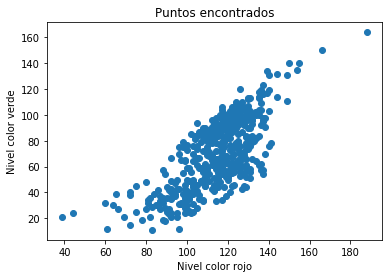

In [32]:
plt.scatter(rojo,verde)
plt.title('Puntos encontrados')
plt.xlabel("Nivel color rojo")
plt.ylabel("Nivel color verde")
plt.savefig(path+name+'grafico_red_green.jpg')
plt.show()

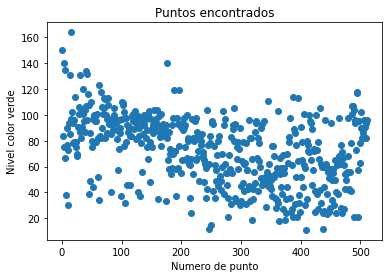

In [33]:
plt.scatter(range(1,len(verde)+1),verde)
plt.title('Puntos encontrados')
plt.xlabel("Numero de punto")
plt.ylabel("Nivel color verde")
plt.show()

#### Histograma colores seleccionados

(100, 105, 29, 0, 117, 88, 103, 123, 123, 114, 115, 127, 44, 52, 106, 130, 116, 126, 105, 129, 118, 133, 101, 122, 110, 112, 92, 123, 120, 83, 115, 100, 100, 108, 111, 102, 118, 91, 82, 129, 125, 128, 115, 91, 89, 85, 125, 124, 119, 117, 91, 124, 103)


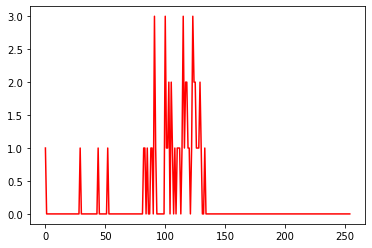

In [18]:
histRselect = []
rojoSel, ex = zip(*arrayGrafVarroaR)
print (rojoSel)
for i in range(255):
    histRselect.append(0)
for r in rojoSel:
    histRselect[r] += 1
plt.plot(histRselect, color='red')
plt.savefig(path+name+'histograma_rojo_sel.jpg')
plt.show()

(73, 94, 28, 0, 93, 57, 46, 77, 70, 65, 61, 66, 24, 36, 67, 77, 48, 94, 41, 74, 80, 80, 36, 45, 57, 43, 43, 56, 52, 29, 49, 50, 37, 34, 54, 39, 44, 27, 21, 52, 79, 105, 62, 23, 28, 30, 65, 62, 54, 56, 42, 78, 41)


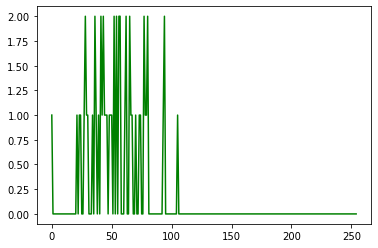

In [19]:
histVselect = []
verdeSel, ex = zip(*arrayGrafVarroaG)
print (verdeSel)
for i in range(255):
    histVselect.append(0)
for r in verdeSel:
    histVselect[r] += 1
plt.plot(histVselect, color='green')
plt.savefig(path+name+'histograma_verde_sel.jpg')
plt.show()

(44, 49, 225, 255, 65, 29, 16, 21, 2, 24, 1, 1, 0, 165, 53, 1, 1, 43, 6, 15, 7, 30, 0, 3, 7, 1, 13, 4, 3, 3, 1, 0, 2, 0, 11, 0, 7, 2, 3, 8, 27, 71, 22, 4, 10, 0, 3, 1, 0, 2, 1, 0, 4)


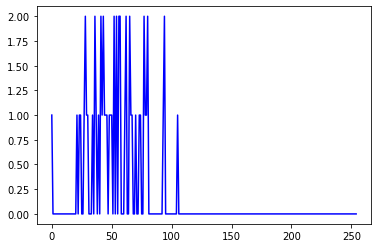

In [20]:
histAselect = []
azulSel, ex = zip(*arrayGrafVarroaB)
print (azulSel)
for i in range(255):
    histAselect.append(0)
for r in verdeSel:
    histAselect[r] += 1
plt.plot(histAselect, color='blue')
plt.savefig(path+name+'histograma_azul_sel.jpg')
plt.show()

#### Graficos según el area

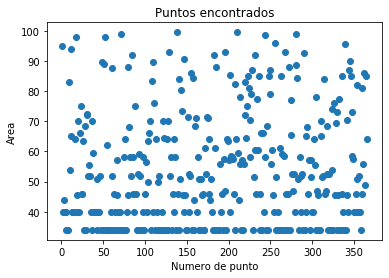

365


In [16]:
arrayArea = []
for cc in cont:
    a = cv2.contourArea(cc)
    if a > 0 and a < 100:
        arrayArea.append(a)
plt.scatter(range(1,len(arrayArea)+1),arrayArea)
plt.title('Puntos encontrados')
plt.xlabel("Numero de punto")
plt.ylabel("Area")
plt.show()
print(len(arrayArea))

### 2.3 Brillo

In [117]:
img = cv2.imread(path+name+'recortada.JPG') #BGR
B,G,R = cv2.split(img)

output1_B = cv2.equalizeHist(B)
output1_G = cv2.equalizeHist(G)
output1_R = cv2.equalizeHist(R)

equ = cv2.merge((output1_B, output1_G, output1_R))
#show_img(equ)
cv2.imwrite(path+name+'equalizar.jpg', equ)

True

In [20]:
img = cv2.imread(path+name+'recortada.JPG') #BGR
font = cv2.FONT_HERSHEY_SIMPLEX
contador = 0
colorBMax = 0
colorGMax = 0
colorRMax = 0
colorBMin = 0
colorGMin = 0
colorRMin = 0
for c in selectedCont:
    grain = np.int0(cv2.boxPoints(cv2.minAreaRect(c)))
    centroid =(grain[2][1]-(grain[2][1]-grain[0][1])//2, grain[2][0]-(grain[2][0]-grain[0][0])//2)
    color = img[centroid]
    if color[0] > colorBMax:
        colorBMax = color[0]
    if color[1] > colorGMax:
        colorGMax = color[1]
    if color[2] > colorRMax:
        colorRMax = color[2]
    if color[0] < colorBMin:
        colorBMin = color[0]
    if color[1] < colorGMin:
        colorGMin = color[1]
    if color[2] < colorRMin:
        colorRMin = color[2]
    

print(colorBMax)
print(colorGMax)
print(colorRMax)
print(colorBMin)
print(colorGMin)
print(colorRMin)

for c in selectedCont:
    grain = np.int0(cv2.boxPoints(cv2.minAreaRect(c)))
    centroid =(grain[2][1]-(grain[2][1]-grain[0][1])//2, grain[2][0]-(grain[2][0]-grain[0][0])//2)
    color = img[centroid]
    
    if ((color[2]/colorRMax)*10) > 8:        
        momentos = cv2.moments(c)
        cx = int(momentos['m10']/momentos['m00'])
        cy = int(momentos['m01']/momentos['m00'])

        cv2.drawContours(img, [c], 0, (255, 0, 0), 2, cv2.LINE_AA) #azul
        cv2.putText(img,"(r: "+str((color[2]/colorRMax)*10)+")",(cx+10,cy+10), font, 0.5,(255,255,255),1)
        
        contador+=1
print("Hay {} varroas".format(contador))

109
150
171
0
0
0
Hay 473 varroas


In [160]:
show_img(img)

In [124]:
cv2.imwrite(path+name+'equalizar_cont.jpg', img)

True

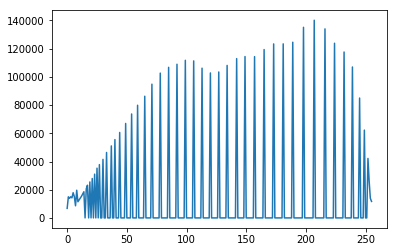

In [50]:
opencvHistRed = cv2.calcHist([equ],[2], None, [256],[0,256])
plt.plot(opencvHistRed)
plt.show()

In [10]:
img = cv2.imread(path+name+'recortada.png') #BGR
img.shape

AttributeError: 'NoneType' object has no attribute 'shape'